### Deep Network Cascade for image Super-resolution 

#### NLSS implementation 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [35]:
img_gray = cv2.imread('../image/sky.jpeg')

In [41]:
def gaussiand_2_level_pyramid(img,kernal_size):
    
    blur_1 = cv2.GaussianBlur(img,(kernal_size,kernal_size),0)
    [h,w,c]  = blur_1.shape
    ## down_sample the blur1 and apply gaussian again 
    d_blur_1 = cv2.resize(blur_1, (0,0), fx=0.5, fy=0.5) 
    d_blur_2 = cv2.GaussianBlur(d_blur_1,(kernal_size,kernal_size),0)
    ## upsample image 
    blur_2 = cv2.resize(d_blur_2,(h,w),0,0, interpolation = cv2.INTER_NEAREST)
    return blur_1, blur_2

In [46]:
def NLSS_serach(img_gray,patch_size,kernal_size):
    ## apply bicubic interpolation 
    img_gray_scale = cv2.resize(img_gray,(0,0),fx=1.37,fy=1.37, interpolation = cv2.INTER_CUBIC)
    
    [h,w,c] = img_gray_scale.shape
    out_img = np.zeros([2*h,2*w,c],dtype='uint8')
    overalp_size = round(patch_size/2)
    
    i = 0
    for row in range (0,h-patch_size,overalp_size):
        j = 0
        for col in range (0,w-patch_size,overalp_size):
            
            patch = img_gray_scale [row:row+patch_size,col:col+patch_size]
            ## apply blur in pathand perform down sampling 
            blur_1, blur_2 = gaussiand_2_level_pyramid(patch,kernal_size)
            mean_patch = blur_1/2.0 + blur_2/2.0        ## averaging instead of gaussina
            
            mean_patch.shape
            #out_img[row:row+path_size,col:col+path_size] = mean_patch
            out_img[i:i+patch_size,j:j+patch_size] = mean_patch
        
            j = j+patch_size
        i = i+patch_size    
    return out_img

In [47]:
#blur_1, blur_2 = gaussiand_2_level_pyramid(img_gray,3)

In [48]:
NLSS_img = NLSS_serach(img_gray,56,5)

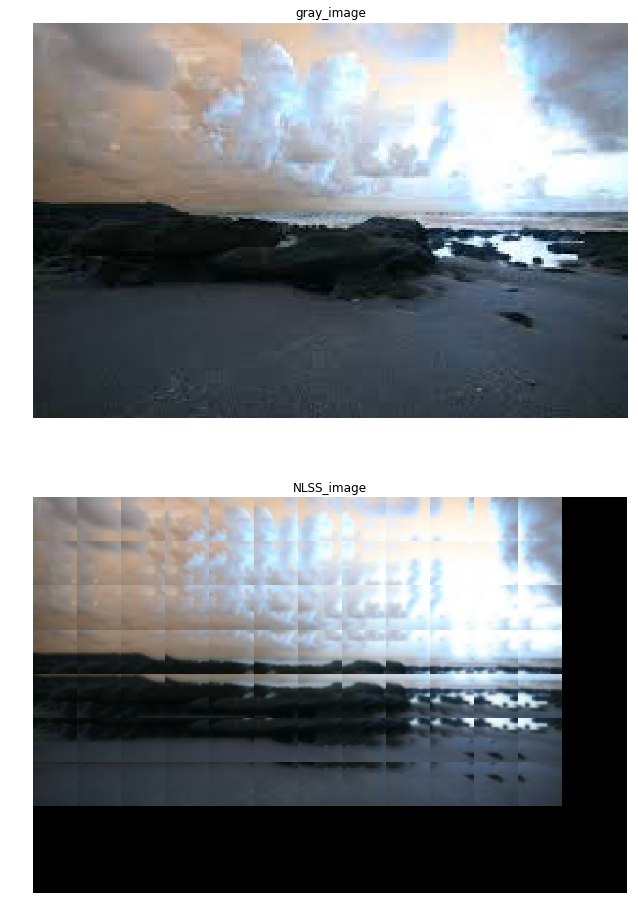

In [49]:
fig=plt.figure(figsize=(16, 16))
columns = 1
rows = 2
fig.add_subplot(rows, columns, 1)
plt.axis("off")
plt.title("gray_image")
plt.imshow(img_gray,cmap='gray')
fig.add_subplot(rows, columns, 2)
plt.axis("off")
plt.title("NLSS_image")
plt.imshow(NLSS_img,cmap='gray')


## Autoencoder basic module 

In [23]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

from tensorflow.python.keras.models import Model,Sequential
from tensorflow.python.keras.optimizers import RMSprop

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

# Scales the training and test data to range between 0 and 1.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

In [ ]:
x_train.shape, x_test.shape

In [ ]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

(x_train.shape, x_test.shape)

In [ ]:
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))
(x_train.shape, x_test.shape)

In [ ]:
x_train_noisy = x_train + np.random.normal(loc=0.0, scale=0.5, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

x_test_noisy = x_test + np.random.normal(loc=0.0, scale=0.5, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Above is one module of  NLSS with autoencoder . We need to train the full stack of netwotk as it uses back projection like resnet architecture.  

### Retrain the model with NLSS data set 

In [9]:
## read NLSS input image generate patch and 

In [10]:
import glob

In [11]:
# reaf training data #
def load_data_from_images(images_path,label_path):
    
    count = 0
    
    data_images = []
    data_labels = []
    for img_path,label_img_path in zip(glob.glob(images_path),glob.glob(label_path)):
        img = cv2.imread(img_path)
        label_img = cv2.imread(img_path)
        
        img1_d  =img.reshape(1,56*56*3)
        label_img1_d  =label_img.reshape(1,56*56*3)
        
        data_images.append(img1_d)
        data_labels.append(label_img1_d)
        if(img_path.split('/')[0] ==label_img_path.split('/')[0] ):
            #print(count)
            count=count+1
        
    data_images = np.squeeze(np.array(data_images))
    data_labels = np.squeeze(np.array(data_labels))
    
    
    train_data = data_images[0:80000,:]
    test_data = data_images[80000:-1,:]
    
    train_labels = data_labels[0:80000,:]
    test_labels = data_labels[80000:-1,:]
    
    

    
    
    print(train_data.shape,train_labels.shape)       
    print(test_data.shape,test_labels.shape)    
    print(count)    
    return train_data,train_labels,test_data,test_labels

In [12]:
images_path = '/home/lord/cv_assignment/cv_project/data_set/NLSS_data_set/train/LR/*.jpg'
label_path = '/home/lord/cv_assignment/cv_project/data_set/NLSS_data_set/train/SR/*.jpg'
train_data,train_labels,test_data,test_labels = load_data_from_images(images_path,label_path)



(80000, 9408) (80000, 9408)
(30469, 9408) (30469, 9408)
110470


In [13]:
train_data = train_data.reshape((len(train_data), 56, 56, 3))
train_labels = train_labels.reshape((len(train_labels), 56, 56, 3))
test_data = test_data.reshape((len(test_data), 56, 56, 3))
test_labels = test_labels.reshape((len(test_labels), 56, 56, 3))





In [14]:
max_value1 = float(train_data.max())
max_value2 = float(train_labels.max())
train_data = train_data.astype('float32') / max_value1
test_data = test_data.astype('float32') / max_value1
train_labels = train_labels.astype('float32') / max_value2
test_labels = test_labels.astype('float32') / max_value2


print(train_data.shape,train_labels.shape)       
print(test_data.shape,test_labels.shape)

(80000, 56, 56, 3) (80000, 56, 56, 3)
(30469, 56, 56, 3) (30469, 56, 56, 3)


### First we need train the basic autoencoder from SR images and downsample images with gaussian blur sigma=1,5,10. 

In [18]:
##
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=train_data.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# Decoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 56, 56, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        9248      
__________

In [22]:
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(train_data, train_labels,
                epochs=10,
                batch_size=128,
                validation_data=(test_data, test_labels))

Train on 80000 samples, validate on 30469 samples
Epoch 1/10
80000/80000 [==============================] - 22s 275us/step - loss: 3.3892e-04 - val_loss: 1.9579e-04
Epoch 2/10
80000/80000 [==============================] - 22s 270us/step - loss: 2.0836e-04 - val_loss: 2.2147e-04
Epoch 3/10
80000/80000 [==============================] - 22s 272us/step - loss: 2.1248e-04 - val_loss: 2.7074e-04
Epoch 4/10
80000/80000 [==============================] - 22s 273us/step - loss: 2.0716e-04 - val_loss: 2.0909e-04
Epoch 5/10
80000/80000 [==============================] - 22s 273us/step - loss: 2.0047e-04 - val_loss: 1.7073e-04
Epoch 6/10
80000/80000 [==============================] - 22s 273us/step - loss: 1.9565e-04 - val_loss: 3.1917e-04
Epoch 7/10
80000/80000 [==============================] - 22s 273us/step - loss: 1.9211e-04 - val_loss: 2.2316e-04
Epoch 8/10
80000/80000 [==============================] - 22s 273us/step - loss: 1.8699e-04 - val_loss: 1.6677e-04
Epoch 9/10
80000/80000 [======

In [ ]:
#autoencoder.fit(x_train_noisy, x_train,
#                epochs=1,
#                batch_size=128,
#                validation_data=(x_test_noisy, x_test))

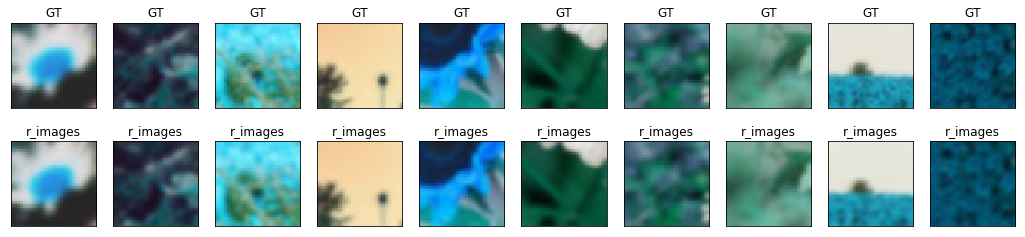

In [34]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(test_data.shape[0], size=num_images)

x_test_denoised = autoencoder.predict(test_data)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(test_labels[image_idx].reshape(56,56,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("GT")
    # plot reconstructed image
    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(x_test_denoised[image_idx].reshape(56,56,3))
    plt.title("r_images")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # plot GT
    #ax = plt.subplot(2, num_images, num_images + i + 1)
    #plt.imshow(test_labels[image_idx].reshape(56,56,3))
    #plt.title("GT images")
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.show()

## inference part 

In [53]:
def inrfrence_autoencoder(patch,max_value1):
    patch = patch.reshape(1,56,56,3)
    patch = patch.astype('float32') / max_value1
    patch1 = np.squeeze(autoencoder.predict(patch))
    return patch1
    
    ############ normalize the patch 
    
    

In [59]:
def infrence_super_resolution(img,autoencoder,max_value1):
    
    #######################################Repeat NLSS process #########################################
    patch_size = 56
    kernal_size = 5
    img_gray_scale = cv2.resize(img,(0,0),fx=1.37,fy=1.37, interpolation = cv2.INTER_CUBIC)
    
    [h,w,c] = img_gray_scale.shape
    out_img = np.zeros([h,w,c],dtype='float')
    overalp_size = round(patch_size/2)
    
    i = 0
    for row in range (0,h-patch_size,overalp_size):
        j = 0
        for col in range (0,w-patch_size,overalp_size):
            
            patch = img_gray_scale [row:row+patch_size,col:col+patch_size]
            ## apply blur in pathand perform down sampling 
            blur_1, blur_2 = gaussiand_2_level_pyramid(patch,kernal_size)
            mean_patch = blur_1/2.0 + blur_2/2.0        ## averaging instead of gaussina
   #################################################################mean patch is NLSS patch ########################
            ## apply the auencoder inference #######################################
            patch1 = inrfrence_autoencoder(patch,max_value1)
            out_img[row:row+patch_size,col:col+patch_size] = out_img[row:row+patch_size,col:col+patch_size]/2.0 + patch1/2.0
    return out_img

In [60]:
img2 = cv2.imread('/home/lord/cv_assignment/cv_project/data_set/images/train/5547758_eea9edfd54_n.jpg')
out_img2 = infrence_super_resolution(img2,autoencoder,max_value1)

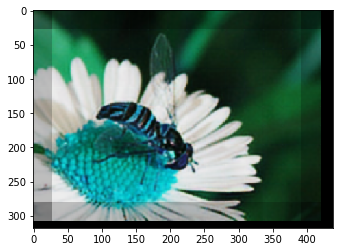

In [61]:
plt.imshow(out_img2)
plt.gray()


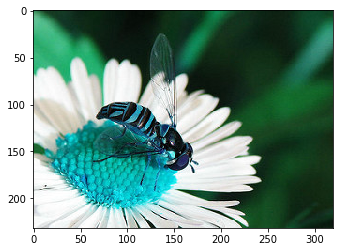

In [62]:
plt.imshow(img2)
plt.gray()